# New Object Detection Dataset

This notebook describes the process of preparing a user-provided dataset (one not included in Hugging Face or Torchvision) for use in Armory Library.

In [1]:
import collections
import csv
import io
import os
from pathlib import Path
from typing import Iterator

import datasets
import pandas as pd
import torch
import torchvision
import torchvision.transforms.functional as F

import armory.data
import armory.dataset
import armory.evaluation
import armory.examples

# [VisDrone 2019 Dataset](https://github.com/VisDrone/VisDrone-Dataset)

Drones equipped with cameras are increasingly used for a variety of applications such as agriculture, aerial photography delivery, and surveillance necessitating advanced automatic visual data analysis through computer vision. The VisDrone2019 dataset, created by the AISKYEYE team at Tianjin University, China, includes 288 video clips and 10,209 images from various drones, providing a comprehensive benchmark with over 2.6 million manually annotated bounding boxes for objects like pedestrians and vehicles across diverse conditions and locations.

We will import the data for the object detection Task 1 challenge. This task aims to detect objects of the predefined categories described above from individual images taken from drones. Google Drive links to the training, validation and test splits are provided in the repository [README](https://github.com/VisDrone/VisDrone-Dataset/blob/master/README.md).

The schema and semantics of the image annotation files are defined in the [VisDrone Toolkit](https://github.com/VisDrone/VisDrone2018-DET-toolkit/blob/master/README.md).

## Download dataset

As a first step, we download the [validation split](https://drive.google.com/file/d/1bxK5zgLn0_L8x276eKkuYA_FzwCIjb59/view?usp=sharing) to a temporary directory. Note that we do not need to unzip the archive for processing as a Hugging Face dataset.

In [2]:
tmp_dir = Path('/tmp')
visdrone_dir = tmp_dir / Path('visdrone_2019')
visdrone_dir.mkdir(exist_ok=True)

visdrone_val_zip = visdrone_dir / Path('VisDrone2019-DET-val.zip')

### Dataset structure

The VisDrone 2019 Task 1 dataset is organized as parallel folders of `images` and `annotations` containing pairs of image and annotation files, respectively.

In [3]:
!unzip -l $visdrone_val_zip '*/0000023_*.*'

unzip:  cannot find or open /tmp/visdrone_2019/VisDrone2019-DET-val.zip, /tmp/visdrone_2019/VisDrone2019-DET-val.zip.zip or /tmp/visdrone_2019/VisDrone2019-DET-val.zip.ZIP.


The annotation files contain object descriptions for each paired image. For each object, one per line, the annotation file includes the bounding box coordinates, the bounding box score, the object category, and truncation and occlusion flags.

The object category indicates the type of annotated object below.
  - ignored regions(0)
  - pedestrian(1)
  - people(2)
  - bicycle(3)
  - car(4)
  - van(5)
  - truck(6)
  - tricycle(7)
  - awning-tricycle(8)
  - bus(9)
  - motor(10)
  - others(11)

In [4]:
!unzip -p $visdrone_val_zip 'VisDrone2019-DET-val/annotations/0000023_00868_d_0000010.txt'

## Load dataset

As a preliminary, we designate the object categories and name the fields in the annotation files.

In [5]:
CATEGORIES = [
    'ignored',
    'pedestrian',
    'people',
    'bicycle',
    'car',
    'van',
    'truck',
    'tricycle',
    'awning-tricycle',
    'bus',
    'motor',
    'other'
]

ANNOTATION_FIELDS = [
    'x',
    'y',
    'width',
    'height',
    'score',
    'category_id',
    'truncation',
    'occlusion'
]

Next, we define the possibly hierarchical features of the dataset by instantiating a [`datasets.Features`](https://huggingface.co/docs/datasets/v2.19.0/en/package_reference/main_classes#datasets.Features) object -- each feature is named and a Hugging Face data type provided.

In [6]:
features = datasets.Features(
    {
        'image_id': datasets.Value('int64'),
        'file_name': datasets.Value('string'),
        'image': datasets.Image(),
        'objects': datasets.Sequence(
            {
                'id': datasets.Value('int64'),
                'bbox': datasets.Sequence(datasets.Value('float32'), length=4),
                'category': datasets.ClassLabel(num_classes=len(CATEGORIES), names=CATEGORIES),
                'truncation': datasets.Value('int32'),
                'occlusion': datasets.Value('int32'),
            }
        )
    }
)

### Loading functions

To load the VisDrone 2019 dataset, we define functions `load_annotations` and `generate_examples`. The `load_annotation` function take a reader for an annotation file, parses each object description into a dictionary and returns a list of object descriptors 

In [7]:
def load_annotations(f: io.BufferedReader) -> list[dict]:
        reader = csv.DictReader(io.StringIO(f.read().decode('utf-8')), fieldnames=ANNOTATION_FIELDS)
        annotations = []
        for idx, row in enumerate(reader):
            category_id = int(row['category_id'])
            annotation = {
                'id': idx,
                'bbox': list(map(float, [row[k] for k in ANNOTATION_FIELDS[:4]])),
                'category': category_id,
                'truncation': row['truncation'],
                'occlusion': row['occlusion']
            }
            annotations.append(annotation)
        return annotations

The `generate_examples` generator is called by Huffing Face to produce the examples in the split being loaded. Note that in this example, the `files` parameter is a reader attached to the VisDrone split archive. The generator assumes that annotation files are read first, and then pairs image files with the corresponding annotations to yield rows of the dataset.

In [8]:
def generate_examples(files: Iterator[tuple[str,io.BufferedReader]], annotation_file_ext:str ='.txt') -> Iterator[tuple[int, dict]]:
    image_to_annotations = {}
    idx = 0
    # This loop relies on the ordering of the files in the archive:
    # Annotation files come first, then the images.
    for path, f in files:
        file_name, _ = os.path.splitext(os.path.basename(path))
        if path.endswith(annotation_file_ext):
            annotations = load_annotations(f)
            image_to_annotations[file_name] = annotations
        elif file_name in image_to_annotations:
            annotations = image_to_annotations[file_name]
            row = {
                "image_id": idx,
                "file_name": file_name,
                "image": {"path": path, "bytes": f.read()},
                "objects": annotations,
            }
            yield row
            idx += 1

Now we create the validation dataset from the split archive by calling [`datasets.Dataset.from_generator`](https://huggingface.co/docs/datasets/v2.19.0/en/package_reference/main_classes#datasets.Dataset.from_generator). Creating a dataset from a generator function is the preferred method, but other options are available (e.g. Pandas dataframe).

In [9]:
visdrone_val_files = datasets.DownloadManager().iter_archive(visdrone_val_zip)

visdrone_dataset = datasets.Dataset.from_generator(
    generate_examples,
    gen_kwargs={
    "files": visdrone_val_files,
    },
    features=features,
    
)
visdrone_dataset

Dataset({
    features: ['image_id', 'file_name', 'image', 'objects'],
    num_rows: 548
})

### Verify dataset

Check that image features, particularly the category names, have been defined correctly.

In [10]:
visdrone_labels = visdrone_dataset.features['objects'].feature['category'].names
visdrone_labels

['ignored',
 'pedestrian',
 'people',
 'bicycle',
 'car',
 'van',
 'truck',
 'tricycle',
 'awning-tricycle',
 'bus',
 'motor',
 'other']

Display a sample image with annotation boxes and category labels.

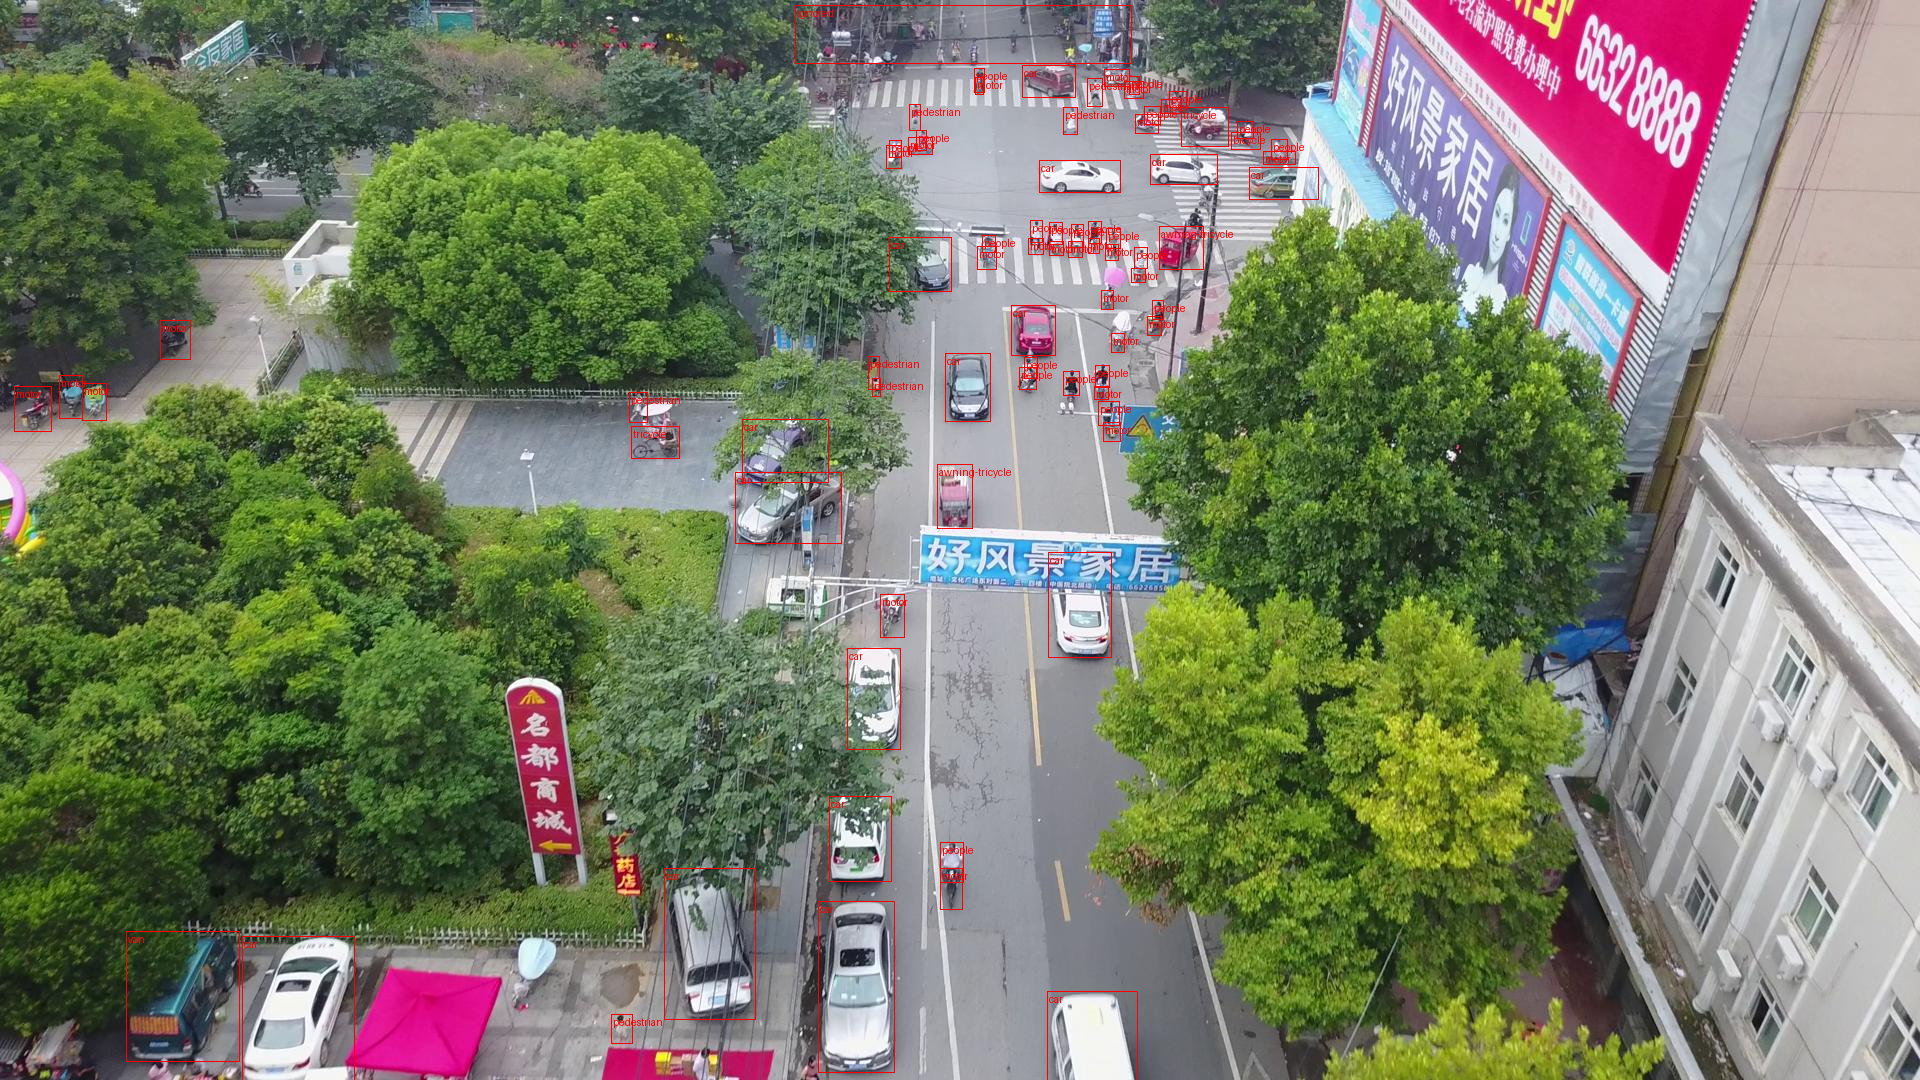

In [11]:
example = visdrone_dataset[1]

boxes_xywh = torch.tensor(example['objects']['bbox'])
boxes_xyxy = torchvision.ops.box_convert(boxes_xywh, 'xywh', 'xyxy')

categories = visdrone_dataset.features['objects'].feature['category'].names
labels = [categories[x] for x in example['objects']['category']]

image = F.to_pil_image(
    torchvision.utils.draw_bounding_boxes(
        F.pil_to_tensor(example['image']),
        boxes_xyxy,
        colors="red",
        labels=labels,
    )
)

display(image)

### Dataset statistics

Using the Hugging Face [`map`](https://huggingface.co/docs/datasets/v2.19.0/en/image_process#map) function that can apply a transform over an entire dataset, we can produce simple statistics that summarize the data. For example, the `count_labels` function accumulates counts of the number of objects of each category that are then used to create a Pandas dataframe.

In [12]:
def count_labels(ds: datasets.Dataset) -> list[int]:
    ctr = collections.Counter()
    def inc_labels(objects: list[dict]) -> None:
        for l in objects['category']:
            ctr[visdrone_labels[l]] += 1
    ds.map(inc_labels, input_columns=['objects'])
    counts = [ctr[l] for l in visdrone_labels]
    return counts

df = pd.DataFrame(
    {'valid': count_labels(visdrone_dataset)},
    index=visdrone_labels
)
df

Map:   0%|          | 0/548 [00:00<?, ? examples/s]

valid
ignored           1378
pedestrian        8844
people            5125
bicycle           1287
car              14064
van               1975
truck              750
tricycle          1045
awning-tricycle    532
bus                251
motor             4886
other               32

A bar chart of the category counts clearly reveals the imbalance of the VisDrone 2019 validation split.

<Axes: title={'center': 'VisDrone Class Counts'}>

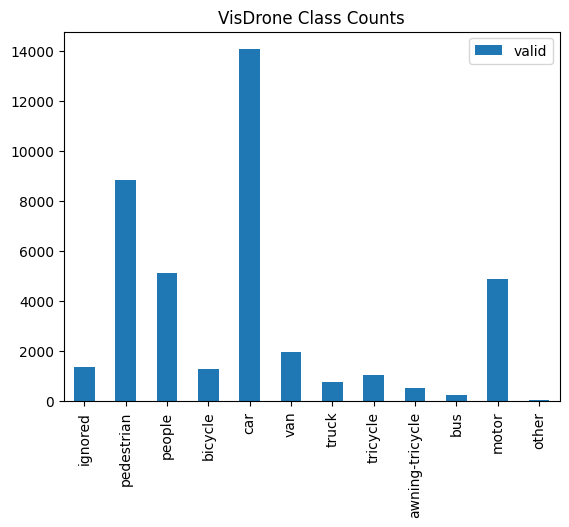

In [13]:
df.plot(kind='bar', 
        title='VisDrone Class Counts')

### Saving to Disk or Uploading to S3 Bucket

The new VisDrone dataset may be [saved to disk](https://huggingface.co/docs/datasets/v2.19.0/en/package_reference/main_classes#datasets.Dataset.save_to_disk) among other options.

In [14]:
visdrone_path = Path('visdrone_2019.hf')    
visdrone_dataset.save_to_disk(visdrone_path)
    
print("Loading the dataset")
print(datasets.load_from_disk(visdrone_path))

Saving the dataset (0/1 shards):   0%|          | 0/548 [00:00<?, ? examples/s]

Loading the dataset
Dataset({
    features: ['image_id', 'file_name', 'image', 'objects'],
    num_rows: 548
})


## Integrate into Armory

Having imported VisDrone 2019 as a Hugging Face dataset, we are ready to plug our new dataset into the Armory Library framework. This consists of creating an `armory.dataset.ObjectDetectionDataLoader` that defines the underlying [PyTorch dataloader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader). The Armory dataloader is then wrapped by an `armory.evaluation.Dataset`.

In [15]:
batch_size = 4
shuffle = False

unnormalized_scale = armory.data.Scale(
    dtype=armory.data.DataType.UINT8,
    max=255,
)

mstar_dataloader = armory.dataset.ObjectDetectionDataLoader(
    visdrone_dataset,
    image_key='image',
    dim=armory.data.ImageDimensions.CHW,
    scale=unnormalized_scale,
    objects_key='objects',
    boxes_key='bbox',
    format=armory.data.BBoxFormat.XYWH,
    labels_key='category',
    batch_size=batch_size,
    shuffle=shuffle,
)

armory_dataset = armory.evaluation.Dataset(
    name="visdrone-2019",
    dataloader=mstar_dataloader,
)

armory_dataset

Dataset(name='visdrone-2019', dataloader=<armory.dataset.ObjectDetectionDataLoader object at 0x2a9ca7b90>)

## Resources
- [VisDrone 2019 Dataset](https://github.com/VisDrone/VisDrone-Dataset)

- [VisDrone Toolkit](https://github.com/VisDrone/VisDrone2018-DET-toolkit/blob/master/README.md)

- [Zhu, P., Wen, L., Du, D., Bian, X., Fan, H., Hu, Q., & Ling, H. (2021). Detection and tracking meet drones challenge. IEEE Transactions on Pattern Analysis and Machine Intelligence, 44(11), 7380-7399.](https://arxiv.org/abs/2001.06303)

- [Hugging Face Datasets](https://huggingface.co/docs/datasets/index)